In [ ]:
!pip install opendatasets
!pip install pandas
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/divg07/casia-20-image-tampering-detection-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: raj
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/divg07/casia-20-image-tampering-detection-dataset


100%|██████████| 2.56G/2.56G [00:21<00:00, 130MB/s] 


In [ ]:
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.models import load_model
# The ImageDataGenerator class has been moved to tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance
!pip install Pillow
from PIL import Image, ImageFilter

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [ ]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
real = '/content/casia-20-image-tampering-detection-dataset/CASIA2/Au'
fake = '/content/casia-20-image-tampering-detection-dataset/CASIA2/Tp'

real_path = os.listdir(real)
fake_path = os.listdir(fake)

print('Real_images :', len(real_path))
print('Fake_images :', len(fake_path))

Real_images : 7492
Fake_images : 5125


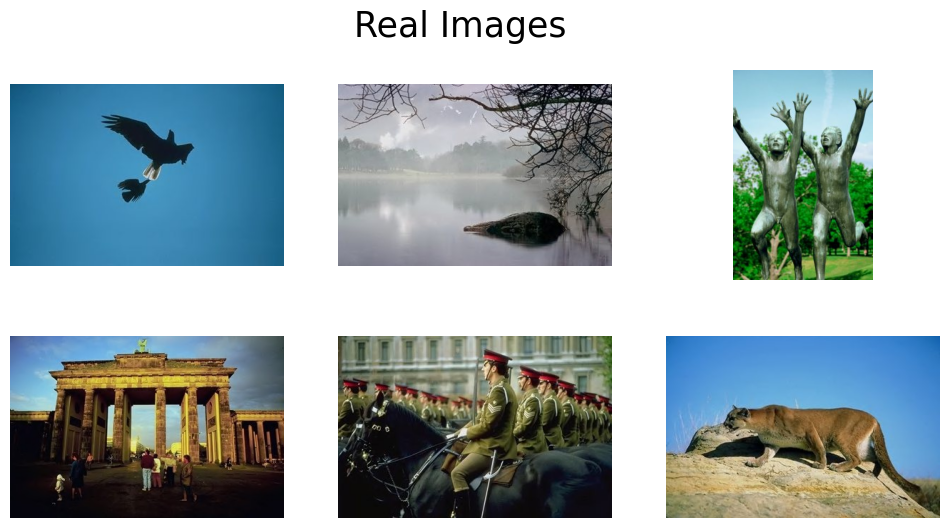

In [ ]:
# Display sample real images
num_images_to_display = 6
plt.figure(figsize=(12, 6))
for i in range(num_images_to_display):
    img_path = os.path.join(real, real_path[i])
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Real Images", fontsize=25)
plt.show()

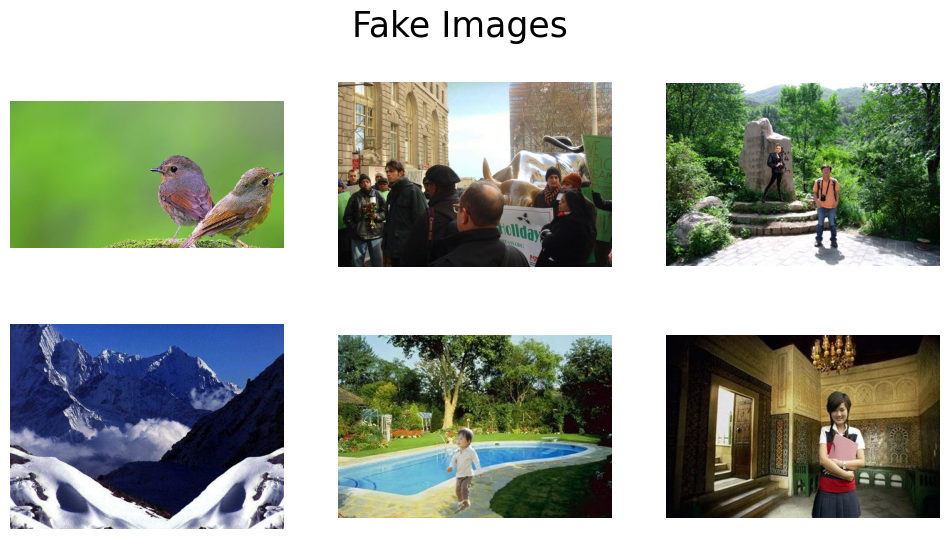

In [ ]:
# Display sample fake images
image_files = [file for file in fake_path if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
plt.figure(figsize=(12, 6))
for i in range(num_images_to_display):
    img_path = os.path.join(fake, image_files[i])
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Fake Images", fontsize=25)
plt.show()

In [ ]:
# Function to convert to ELA image
def convert_to_ela_image(path, quality=90):
    temp_filename = 'temp_ela.jpg'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality=quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

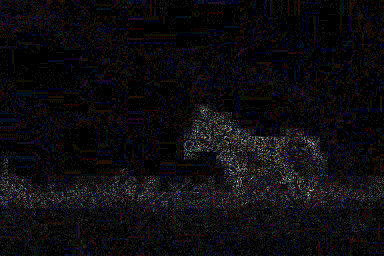

In [ ]:
real_image_path = r'/content/casia-20-image-tampering-detection-dataset/CASIA2/Au/Au_ani_00001.jpg'
Image.open(real_image_path)
convert_to_ela_image(real_image_path, 90)

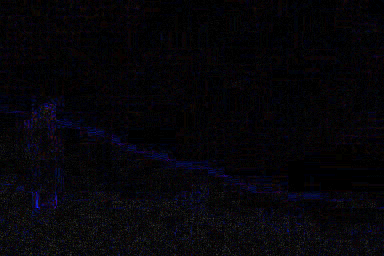

In [ ]:
fake_image_path=r"/content/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_D_CNN_M_N_nat00013_cha00042_11093.jpg"
Image.open(fake_image_path)
convert_to_ela_image(fake_image_path, 90)

In [ ]:
# Preprocessing function with resizing and denoising
image_size = (128, 128)
def prepare_image(image_path):
    ela_image = convert_to_ela_image(image_path)
    ela_image = ela_image.resize(image_size)
    ela_image = ela_image.filter(ImageFilter.MedianFilter(size=3))  # Denoising
    return np.array(ela_image).flatten() / 255.0  # Normalize and flatten

In [ ]:
# Data Augmentation Configuration
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotations
    width_shift_range=0.2,  # Random width shifts
    height_shift_range=0.2,  # Random height shifts
    shear_range=0.15,  # Shear transformations
    zoom_range=0.2,  # Random zooms
    horizontal_flip=True,  # Horizontal flips
    brightness_range=[0.8, 1.2],  # Random brightness adjustments
    fill_mode='nearest'  # Filling strategy for empty pixels
)

In [ ]:
#Gaussian Noise Injection
def add_gaussian_noise(image):
    mean = 0
    stddev = 0.05
    noise = np.random.normal(mean, stddev, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

In [ ]:
# Prepare datasets for real and fake images
X = []  # Images
Y = []  # Labels

In [ ]:
import random
for dirname, _, filenames in os.walk(real):

    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:1000]
Y = Y[:1000]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
1000 1000


In [ ]:
for dirname, _, filenames in os.walk(fake):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
3064 3064


In [ ]:
print(f'Total images processed: {len(X)}')

Total images processed: 3064


In [ ]:
# Convert to arrays and perform train-test split
X = np.array(X)
Y = to_categorical(Y, 2)  # One-hot encode labels
X = X.reshape(-1, 128, 128, 3)  # Reshape for CNN input

In [ ]:
# Apply ZCA Whitening using ImageDataGenerator
datagen.fit(X)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

2451 2451
613 613


In [ ]:
# building a convolutional neural network (CNN) for image classification using TensorFlow/Keras. Here's the model architecture I’ve defined:
!pip install --upgrade tensorflow
def build_model():
    model = Sequential()
    # A sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    #transforms the 2D array into a 1D array
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model
model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 124, 124, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 120, 120, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      29,491,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,520,034 (112.61 MB)

 Trainable params: 29,520,034 (112.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 30
batch_size = 32
init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'max')

In [ ]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.6997 - loss: 0.6201 - val_accuracy: 0.8499 - val_loss: 0.3922
Epoch 2/30
 5/77 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8531 - loss: 0.3708

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8814 - loss: 0.3529 - val_accuracy: 0.8825 - val_loss: 0.3341
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8924 - loss: 0.3273 - val_accuracy: 0.8695 - val_loss: 0.3504
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9051 - loss: 0.2972 - val_accuracy: 0.8940 - val_loss: 0.3242
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8946 - loss: 0.3093 - val_accuracy: 0.8891 - val_loss: 0.3109
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9149 - loss: 0.2801 - val_accuracy: 0.8891 - val_loss: 0.3020
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9153 - loss: 0.2701 - val_accuracy: 0.8842 - val_loss: 0.3211
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9169 - loss: 0.2677 - val_accuracy: 0.8972 - val_loss: 0.2989
Epoch 9/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9259 - loss: 0.2486 - val_accuracy: 0.8956 - val_loss: 0.

In [ ]:
model.save('model_casia_run1.h5')

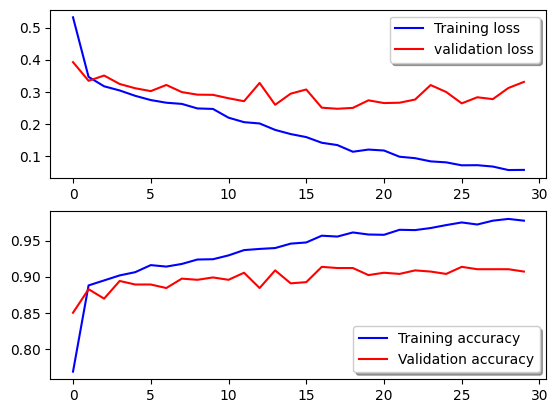

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss") # Remove axes=ax[0]
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


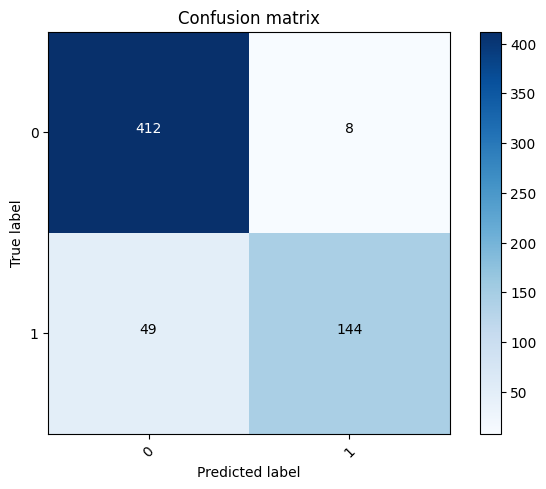

In [ ]:
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [ ]:
#"I have implemented a script to classify images as 'fake' or 'real' using model. The code loads and prepares images, makes predictions, and then prints the predicted class along with the confidence score.
class_names = ['fake', 'real']
real_image_path = r'/content/casia-20-image-tampering-detection-dataset/CASIA2/Au/Au_ani_00001.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

fake_image_path=r"/content/casia-20-image-tampering-detection-dataset/CASIA2/Tp/Tp_D_NRN_S_N_ani10171_ani00001_12458.jpg"
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
Class: real Confidence: 99.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Class: fake Confidence: 99.99


In [ ]:
fake_image = os.listdir('/content/casia-20-image-tampering-detection-dataset/CASIA2/Tp')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('/content/casia-20-image-tampering-detection-dataset/CASIA2/Tp', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [ ]:
#loop to display the total number of images processed, the number of correct predictions, and the accuracy of the model
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 2064, Correct: 2055, Acc: 99.56395348837209


In [ ]:
real_image = os.listdir('/content/casia-20-image-tampering-detection-dataset/CASIA2/Au')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('/content/casia-20-image-tampering-detection-dataset/CASIA2/Au', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

In [ ]:
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')

Total: 7437, Correct: 6140, Acc: 82.56017211241092


In [ ]:
correct += correct_r
total += total_r
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 9501, Correct: 8195, Acc: 86.25407851805073


In [ ]:
TP = confusion_mtx[1, 1]
TN = confusion_mtx[0, 0]
FP = confusion_mtx[0, 1]
FN = confusion_mtx[1, 0]

# Calculate precision
precision = TP / float(TP + FP)

# Calculate recall
recall = TP / float(TP + FN)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.9473684210526315
Recall: 0.7461139896373057
F1 Score: 0.8347826086956522
